In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import os

# Generate names
* Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train NN instead.
* Dataset contains ~8k human names from different cultures[in latin transcript]
* Objective (toy problem): learn a generative model over names.

In [2]:
start_token = " "

with open("names") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token+name for name in names]
    

In [3]:
print 'n samples = ',len(names)
for x in names[::1000]:
    print x

n samples =  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


# Text processing

In [4]:
#all unique characters go here
token_set = set()
for name in names:
    for letter in name:
        token_set.add(letter)

tokens = list(token_set)

print 'n_tokens = ',len(tokens)


n_tokens =  55


In [5]:
#!token_to_id = <dictionary of symbol -> its identifier (index in tokens list)>
token_to_id = {t:i for i,t in enumerate(tokens) }

#!id_to_token = < dictionary of symbol identifier -> symbol itself>
id_to_token = {i:t for i,t in enumerate(tokens)}

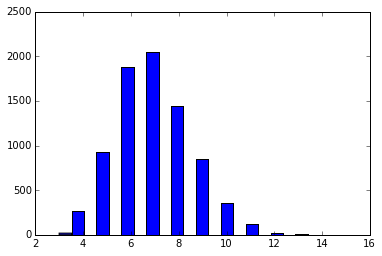

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(map(len,names),bins=25);

# truncate names longer than MAX_LEN characters. 
MAX_LEN = min([60,max(list(map(len,names)))])
#ADJUST IF YOU ARE UP TO SOMETHING SERIOUS


### Cast everything from symbols into identifiers

In [7]:
names_ix = list(map(lambda name: list(map(token_to_id.get,name)),names))


#crop long names and pad short ones
for i in range(len(names_ix)):
    names_ix[i] = names_ix[i][:MAX_LEN] #crop too long
    
    if len(names_ix[i]) < MAX_LEN:
        names_ix[i] += [token_to_id[" "]]*(MAX_LEN - len(names_ix[i])) #pad too short
        
assert len(set(map(len,names_ix)))==1

names_ix = np.array(names_ix)

# Input variables

In [8]:
from agentnet import Recurrence
from lasagne.layers import *
from agentnet.memory import *
from agentnet.resolver import ProbabilisticResolver

In [9]:
sequence = T.matrix('token sequence','int64')

inputs = sequence[:,:-1]
targets = sequence[:,1:]


l_input_sequence = InputLayer(shape=(None, None),input_var=inputs)


# Build NN

You'll be building a model that takes token sequence and predicts next tokens at each tick

This is basically equivalent to how rnn step was described in the lecture

In [10]:
###One step of rnn
class step:
    
    #inputs
    inp = InputLayer((None,),name='current character')
    h_prev = InputLayer((None,10),name='previous rnn state')
    
    #recurrent part
    emb = <embed tokens>
    
    h_new = <recurrent neural network>
    
    next_token_probas = <next token probas>
    
    #pick next token from predicted probas
    next_token = ProbabilisticResolver(next_token_probas)
    


SyntaxError: invalid syntax (<ipython-input-10-c8650b6fa518>, line 9)

In [ ]:
training_loop = Recurrence(
    state_variables={step.h_new:step.h_prev},
    input_sequences={step.inp:l_input_sequence},
    tracked_outputs=[step.next_token_probas,],
    unroll_scan=False,
)


In [ ]:
# Model weights
weights = lasagne.layers.get_all_params(training_loop,trainable=True)
print weights

In [ ]:
predicted_probabilities = lasagne.layers.get_output(training_loop[step.next_token_probas])
#If you use dropout do not forget to create deterministic version for evaluation

In [ ]:

loss = lasagne.objectives.categorical_crossentropy(predicted_probabilities.reshape((-1,len(tokens))),
                                                   targets.reshape((-1,))).mean()
#<Loss function - a simple categorical crossentropy will do, maybe add some regularizer>

updates = lasagne.updates.adam(loss,weights)

# Compiling it

In [ ]:

#training
train_step = theano.function([sequence], loss,
                             updates=training_loop.get_automatic_updates()+updates)


# generation

here we re-wire the recurrent network so that it's output is fed back to it's input

In [ ]:
n_steps = T.scalar(dtype='int32')
feedback_loop = Recurrence(
    state_variables=<...>,
    tracked_outputs=<...>,
    batch_size=theano.shared(1),
    n_steps=n_steps,
    unroll_scan=False,
)


In [ ]:
generated_tokens = <get generated tokens>

In [ ]:
generate_sample = theano.function(<inputs>,<outputs>, updates=feedback_loop.get_automatic_updates())

In [ ]:
def generate_string(length=MAX_LEN):
    output_indices = generate_sample(length)[0]
    return ''.join(tokens[i] for i in output_indices)
    

In [ ]:
generate_string()

# Model training

Here you can tweak parameters or insert your generation function


__Once something word-like starts generating, try increasing seq_length__



In [ ]:
def sample_batch(data, batch_size):
    
    rows = data[np.random.randint(0,len(data),size=batch_size)]
    
    return rows

In [ ]:

print("Training ...")


#total N iterations
n_epochs=100

# how many minibatches are there in the epoch 
batches_per_epoch = 500

#how many training sequences are processed in a single function call
batch_size=10


for epoch in xrange(n_epochs):

    avg_cost = 0;
    for _ in range(batches_per_epoch):
        
        avg_cost += train_step(sample_batch(names_ix,batch_size))
        
    print("\n\nEpoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch))

    print "Generated names"
    for i in range(10):
        print generate_string(),


# And now,
* try lstm/gru
* try several layers
* try mtg cards
* try your own dataset of any kind